


Compute the closing stock price for a day, given the opening stock price for that day, and previous some $d$ days data. The predictor would have a latency of $d$ days.

The predictor will contain all the logic to predict the stock price of a given company during a given day.

Instead of directly using the opening, closing, low, and high prices of a stock, the model extracts the fractional changes in each of them that would be used to train the HMM.

$frac_{change} = \frac{(close-open)} {open} $

$frac_{high} = \frac{(high-open)} {open} $

$frac_{low} = \frac{(open-low)} {open} $

In [ ]:
!pip install hmmlearn

In [ ]:
!pip install yfinance

In [465]:
import pandas as pd
import numpy as np
import scipy as sp 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from hmmlearn.hmm import GaussianHMM

In [466]:
today = datetime.today()
days = timedelta(days=500)
start = today-days

In [524]:
stk = 'SOFI'
stk = yf.download(stk, start, today)
stk['frac_high'] = (stk['High'] - stk['Open'])/stk['Open']
stk['frac_low'] = (stk['Open'] - stk['Low'])/stk['Open']

[*********************100%***********************]  1 of 1 completed


In [525]:
stk.head(3)

,Open,High,Low,Close,Adj Close,Volume,frac_high,frac_low
Date,,,,,,,,
2021-01-04,12.59,12.59,11.80,12.20,12.20,1371400,0.000000,0.062748
2021-01-05,12.15,12.28,12.09,12.15,12.15,1304000,0.010700,0.004938
2021-01-06,12.15,12.20,11.89,12.12,12.12,1105700,0.004115,0.021399


In [526]:
stk.tail(3)

,Open,High,Low,Close,Adj Close,Volume,frac_high,frac_low
Date,,,,,,,,
2022-03-09,9.96,10.090,9.645,9.87,9.87,53891100,0.013052,0.031626
2022-03-10,9.71,9.820,9.180,9.41,9.41,47638400,0.011328,0.054583
2022-03-11,9.51,9.537,8.520,8.55,8.55,71259800,0.002839,0.104101


In [527]:
data = stk[['Open', 'frac_high', 'frac_low', 'Close']]

As the observations are a vector of
continuous random variables, we have to assume that the emission probability distribution
is continuous. For simplicity, let's assume that it is a multinomial Gaussian distribution
with parameters (μ and Σ). So we have to determine the following parameters for the
transition matrix, A, prior probabilities, π, along with μ and Σ which represent the
multinomial Gaussian distribution.

In [528]:
hmm = GaussianHMM(n_components=5)

In [529]:
from sklearn.model_selection import train_test_split

In [530]:
X_train, X_test = train_test_split(data, test_size=0.33, shuffle=False)

In [531]:
hmm.fit(X_train)

GaussianHMM(n_components=5)

In [532]:
X_train

,Open,frac_high,frac_low,Close
Date,,,,
2021-01-04,12.590000,0.000000,0.062748,12.200000
2021-01-05,12.150000,0.010700,0.004938,12.150000
2021-01-06,12.150000,0.004115,0.021399,12.120000
2021-01-07,12.200000,0.803279,0.012295,19.139999
2021-01-08,21.459999,0.025163,0.166356,18.740000
...,...,...,...,...
2021-10-13,19.000000,0.016316,0.026842,18.920000
2021-10-14,19.799999,0.000505,0.043182,19.620001
2021-10-15,19.559999,0.015337,0.012270,19.379999


In [533]:
train_predictions = hmm.predict(X_train)

In [534]:
test_predictions = hmm.predict(X_test)

In [535]:
train_predictions = pd.DataFrame(train_predictions)
train_predictions

,0
0,3
1,3
2,3
3,1
4,2
...,...
196,2
197,2
198,2
199,0


In [536]:
test_predictions = pd.DataFrame(test_predictions)
test_predictions

,0
0,3
1,2
2,0
3,0
4,0
...,...
94,3
95,3
96,3
97,3


In [537]:
predictions = pd.concat([train_predictions, test_predictions])
predictions.index = data.index

In [538]:
predictions

,0
Date,
2021-01-04,3
2021-01-05,3
2021-01-06,3
2021-01-07,1
2021-01-08,2
...,...
2022-03-07,3
2022-03-08,3
2022-03-09,3


In [539]:
data['layers'] = predictions
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,frac_high,frac_low,Close,layers
Date,,,,,
2021-01-04,12.590000,0.000000,0.062748,12.200000,3
2021-01-05,12.150000,0.010700,0.004938,12.150000,3
2021-01-06,12.150000,0.004115,0.021399,12.120000,3
2021-01-07,12.200000,0.803279,0.012295,19.139999,1
2021-01-08,21.459999,0.025163,0.166356,18.740000,2
...,...,...,...,...,...
2022-03-07,9.975000,0.024561,0.038597,9.620000,3
2022-03-08,9.510000,0.060883,0.024185,9.720000,3
2022-03-09,9.960000,0.013052,0.031626,9.870000,3


In [540]:
data['layers'].value_counts()

3    179
2     48
4     47
0     23
1      3
Name: layers, dtype: int64

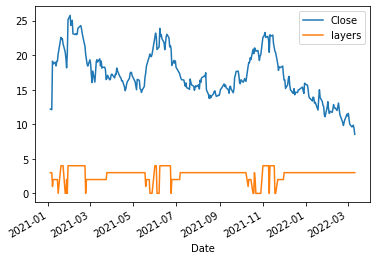

In [541]:
data[['Close', 'layers']].plot()

In [542]:
data.corr()['Close'].sort_values(ascending=False)

Close        1.000000
Open         0.973215
frac_high    0.081029
layers      -0.021252
frac_low    -0.029450
Name: Close, dtype: float64

In [543]:
data.corr()

,Open,frac_high,frac_low,Close,layers
Open,1.000000,-0.096839,0.105038,0.973215,-0.018981
frac_high,-0.096839,1.000000,-0.236154,0.081029,-0.074642
frac_low,0.105038,-0.236154,1.000000,-0.029450,-0.099428
Close,0.973215,0.081029,-0.029450,1.000000,-0.021252
layers,-0.018981,-0.074642,-0.099428,-0.021252,1.000000


In [544]:
from sklearn.ensemble import GradientBoostingRegressor
X = data.drop(['Close', 'Open'], axis=1)
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101, shuffle=False)
GBR = GradientBoostingRegressor().fit(X_train, y_train)

In [545]:
GBR.score(X_train,y_train)

0.9567131383220059

In [546]:
GBR.score(X_test,y_test)

0.33635522702527787

In [547]:
GBR_predictions = GBR.predict(X_test)

In [548]:
GBR_predictions

array([22.35907622, 22.68260078, 22.35023291, 22.80556324, 22.07920297,
       21.97257642, 20.0408268 , 22.89285791, 22.42062397, 22.80384891,
       23.30997804, 22.67679741, 20.01921103, 20.26615616, 18.12856095,
       17.12237474, 18.26024341, 18.41456243, 18.57255938, 18.45715796,
       15.7029137 , 16.05291845, 15.35722475, 16.33536984, 15.60163383,
       16.21062369, 15.37118801, 16.44710816, 16.61667455, 15.82996102,
       16.50388636, 15.30976569, 16.53609776, 16.19365248, 14.71470913,
       15.82996102, 15.25768758, 16.34931096, 15.85590917, 16.02817378,
       16.64899479, 17.16676089, 15.09088197, 15.46622334, 16.61667455,
       15.2854227 , 16.20277777, 15.48527972, 15.87961314, 16.12139551,
       14.81267282, 16.31656851, 16.61667455, 14.93307957, 16.61147199,
       15.10406248, 16.15501741, 16.60047805, 16.44389144, 15.98357539,
       14.87990022, 16.60807872, 16.50388636, 14.98365574, 16.59974612,
       16.41702485, 16.37842922, 16.35990269, 16.15295474, 15.76

In [549]:
y_test

Date
2021-11-02    22.680000
2021-11-03    22.959999
2021-11-04    23.290001
2021-11-05    22.570000
2021-11-08    22.740000
                ...    
2022-03-07     9.620000
2022-03-08     9.720000
2022-03-09     9.870000
2022-03-10     9.410000
2022-03-11     8.550000
Name: Close, Length: 90, dtype: float64

In [550]:
import numpy as np

importances = GBR.feature_importances_

indices = np.argsort(importances)

In [551]:
Features = X_train.columns

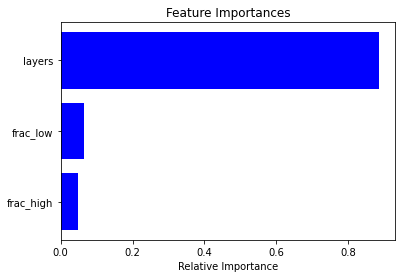

In [552]:
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()